In [1]:
import sys
sys.path.append("..")
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from semif_utils.utils import make_exg, thresh_vi, crop_cutouts, clean_mask, dilate_erode,get_image_meta, otsu_thresh, manual_bbox
from semif_utils.segment_utils import prep_bbox
from skimage.segmentation import active_contour
from skimage.filters import gaussian
from skimage.draw import polygon
from skimage.measure import find_contours, approximate_polygon
from sklearn.cluster import KMeans

In [2]:
def display_multiple_img(images, rows = 1, cols=1, figsize=(12,8)):
    figure, ax = plt.subplots(nrows=rows,ncols=cols, figsize=figsize)
    for ind,img in enumerate(images):
        ax.ravel()[ind].imshow(img)
        # ax.ravel()[ind].set_axis_off()
    plt.tight_layout()
    plt.show()

[9560.0, 6368.0]
2356.0001632
2539.9997024
3212.000348
3443.9995599999997


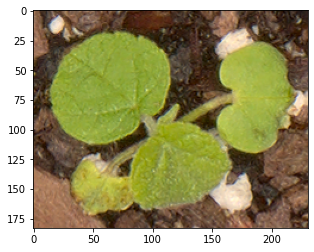

[9560.0, 6368.0]
4968.0002944
5944.0000928
5271.999664
6040.000352


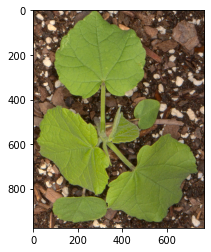

[9560.0, 6368.0]
2604.0000128
3092.0002304
2393.999904
2949.999944


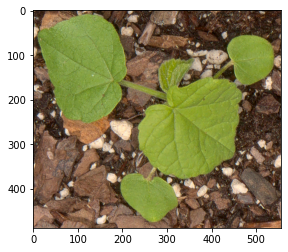

[9560.0, 6368.0]
2567.9997984
3320.0001024
300.000448
1212.999568


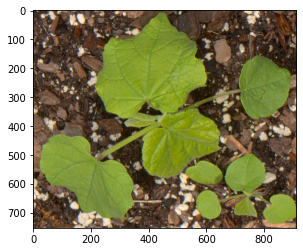

[9560.0, 6368.0]
4852.0001696
5083.9997824
443.99986
619.00044


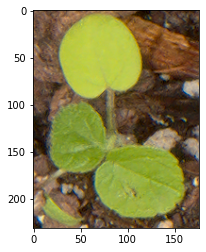

[9560.0, 6368.0]
5935.9999744
6263.9997344
1053.99956
1500.000328


KeyboardInterrupt: 

In [3]:
import pandas as pd
jsons = [x for x in Path("../data/semifield-developed-images/MD_2022-06-28/metadata").glob("*json")]
imgs = []

df = pd.read_csv("../data/semifield-developed-images/MD_2022-06-28/autosfm/detections.csv")
scale = (9560, 6368)

for j in jsons[:10]:
    imgdata = get_image_meta(j)
    imgs.append(imgdata)
    imgdata.blob_home = "../data"
    img_name = imgdata.image_id + ".jpg"
    imgdf = df[df["imgname"] == img_name]
    img_dict = imgdf.to_dict("records")

    scale = [float(imgdata.fullres_width), float(imgdata.fullres_height)]
    for box in img_dict:
        x1, y1, x2, y2 = manual_bbox(box, scale)
        img = imgdata.array
        img = img[y1:y2, x1:x2]

        plt.imshow(img)
        plt.show()
        

2999 2486 3651 3110
(591, 618, 3)


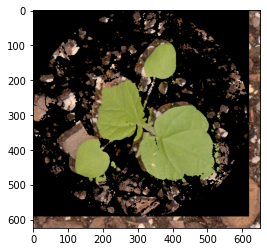

5692 2809 6389 3385
(543, 644, 3)


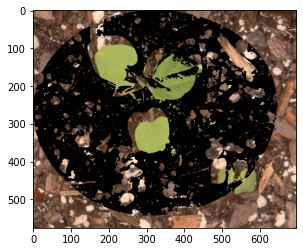

7944 5550 9227 6236
(668, 1233, 3)


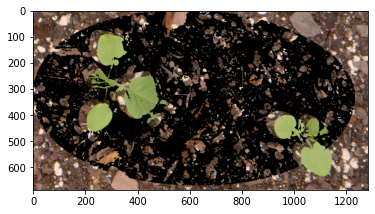

2803 5776 3442 6171
(391, 622, 3)


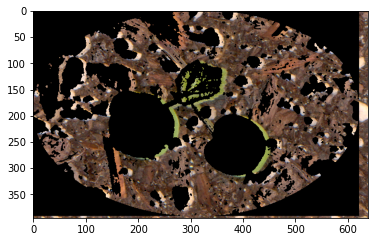

7760 2511 8441 3104


KeyboardInterrupt: 

In [ ]:
for imgdata in imgs:
    # Call image array
    imgdata.blob_home = "../data"
    img = imgdata.array
    # Get bboxes
    bboxes = imgdata.bboxes
    for box in bboxes:
        # Scale the box that will be used for the cutout
        scale = [imgdata.fullres_width, imgdata.fullres_height]
        box, x1, y1, x2, y2 = prep_bbox(box, scale)
        
        print(x1, y1, x2, y2)
        rgb_crop = img[y1:y2, x1:x2]
        cotyledon_cutout = process_cotyledon(rgb_crop, [y2, y1, x1, x2])
        plt.imshow(cotyledon_cutout)
        plt.show()

In [ ]:
kmeans_model = KMeans(n_clusters=3) # we shall retain only 7 colors
(h,w,c) = cutout.shape
img2D = cutout.reshape(h*w,c)
cluster_labels = kmeans_model.fit_predict(img2D)
labels_count = Counter(cluster_labels)
rgb_cols = kmeans_model.cluster_centers_.round(0).astype(int)
colors = [50, 150, 250]
rgb_cols[0] = np.array([50, 50, 50])
rgb_cols[1] = np.array([150, 150, 150])
rgb_cols[2] = np.array([250, 250, 250])

img_quant = np.reshape(rgb_cols[cluster_labels],(h,w,c))
plt.figure(figsize=(12,8))
plt.imshow(img_quant)

NameError: name 'cutout' is not defined

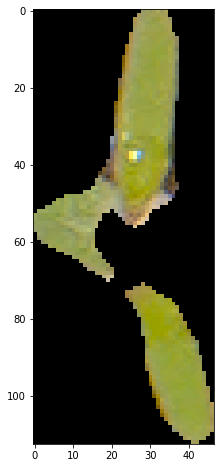

In [27]:
color_sums = {num: (img_quant == num).sum() for num in colors}
color_sums = sorted(color_sums.items(), key=lambda x: x[1], reverse=True)
threshold_val = color_sums[1][0]
quant_mask = np.where(img_quant == threshold_val, 255, 0)[:,:,0]
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))

closing = cv2.morphologyEx(quant_mask.astype("int16"), cv2.MORPH_CLOSE, kernel)
# closing = cv2.morphologyEx(closing, cv2.MORPH_CLOSE, kernel)

cleaned_mask = clean_mask(closing)
# kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
# dilated_mask = cv2.dilate(cleaned_mask, kernel2, iterations = 1)
# dilate_erode_mask = dilate_erode(cleaned_mask, kernel_size=5, dil_iters=5, eros_iters=5, hole_fill=True)


# Mask the array
array_data = cutout.copy()
array_data[np.where(cleaned_mask == 0)] = 0
cutout2 = crop_cutouts(array_data)
# reduce_holes
plt.figure(figsize=(12,8))
plt.imshow(cutout2)

In [ ]:
# For using find_contours
# get most significant contours
contours_mask, hierachy = cv2.findContours(exg, cv2.RETR_EXTERNAL,
                                        cv2.CHAIN_APPROX_NONE)

mask = np.zeros(img.shape, np.uint8)

# find the biggest countour (c) by the area
c = max(contours_mask, key = cv2.contourArea)
cv2.drawContours(mask, [c], -1, (255),1)
# mask[c[0], c[1]] = 255
cv2.imwrite('mask.png', mask)
    

In [ ]:
# from semif_utils.utils import make_exg, thresh_vi, crop_cutouts, clean_mask
# reduce_holes,dilate_erode, filter_topn_components, seperate_components
# from scipy import ndimage as ndi
# from skimage.util import random_noise
# from skimage import feature




# from skimage import data
# from skimage import color


# from skimage.filters import meijering, sato, frangi, hessian
# import matplotlib.pyplot as plt
# sys.path.append("..")

# from pathlib import Path
# from skimage.color import rgb2hed, hed2rgb
# from skimage.color.adapt_rgb import adapt_rgb, each_channel, hsv_value
# from skimage.measure import find_contours, approximate_polygon, \
#     subdivide_polygon

# import numpy.ma as ma
# from skimage import filters
# from skimage.exposure import rescale_intensity
# from skimage.util import invert
# from skimage.morphology import convex_hull_image
# from skimage import data, img_as_float

# Scratch downward

Text(0.5, 1.0, 'Sobel filter computed\n on (V)alue converted image (HSV)')

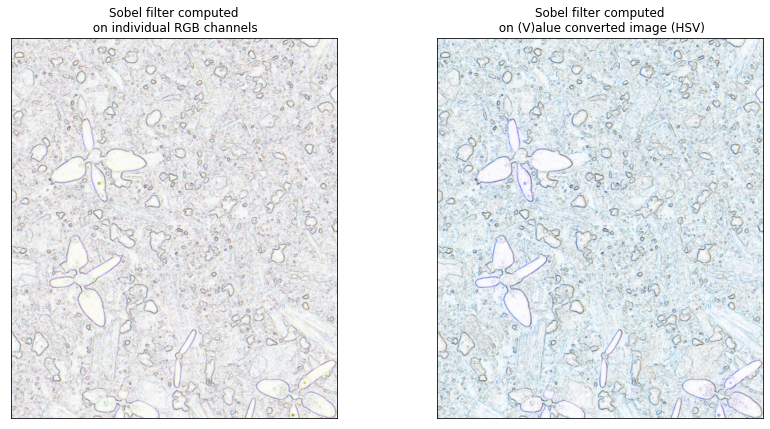

In [3]:
@adapt_rgb(each_channel)
def sobel_each(image):
    return filters.sobel(image)


@adapt_rgb(hsv_value)
def sobel_hsv(image):
    return filters.sobel(image)
    
im = cv2.imread(path)
img = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
image = img[2500:3200,7200:7800]

fig, (ax_each, ax_hsv) = plt.subplots(ncols=2, figsize=(14, 7))

# We use 1 - sobel_each(image) but this won't work if image is not normalized
ax_each.imshow(rescale_intensity(1 - sobel_each(image)))
ax_each.set_xticks([]), ax_each.set_yticks([])
ax_each.set_title("Sobel filter computed\n on individual RGB channels")

# We use 1 - sobel_hsv(image) but this won't work if image is not normalized
ax_hsv.imshow(rescale_intensity(1 - sobel_hsv(image)))
ax_hsv.set_xticks([]), ax_hsv.set_yticks([])
ax_hsv.set_title("Sobel filter computed\n on (V)alue converted image (HSV)")

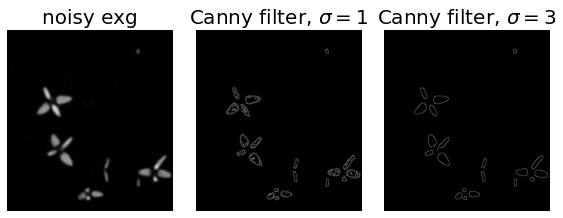

In [4]:
im = cv2.imread(path)
img = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
image = img[2500:3200,7200:7800]
exg = make_exg(image)
exg = ndi.rotate(exg, 15, mode='constant')
exg = ndi.gaussian_filter(exg, 4)
exg = random_noise(exg, mode='speckle', mean=0.1)

# Compute the Canny filter for two values of sigma
edges1 = feature.canny(exg)
edges2 = feature.canny(exg, sigma=3)

# display results
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 3))

ax[0].imshow(exg, cmap='gray')
ax[0].set_title('noisy exg', fontsize=20)

ax[1].imshow(edges1, cmap='gray')
ax[1].set_title(r'Canny filter, $\sigma=1$', fontsize=20)

ax[2].imshow(edges2, cmap='gray')
ax[2].set_title(r'Canny filter, $\sigma=3$', fontsize=20)

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()

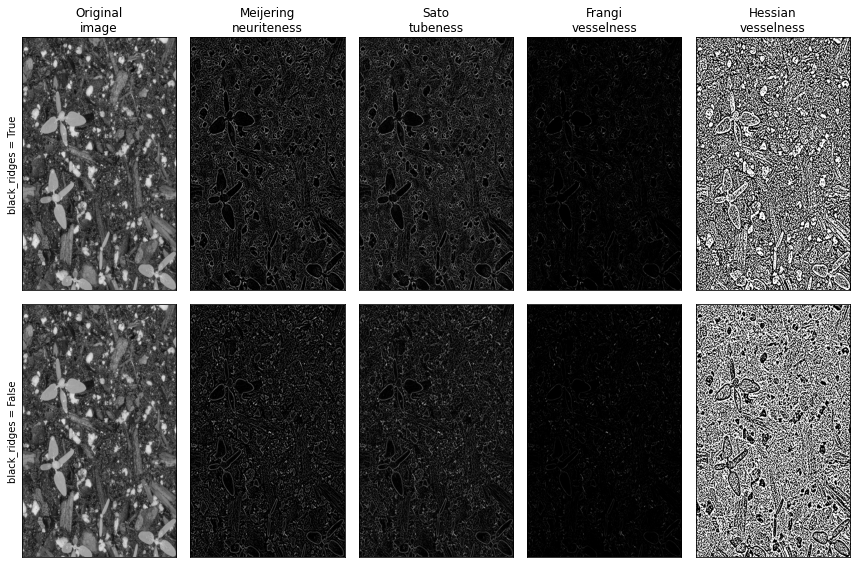

In [5]:



def identity(image, **kwargs):
    """Return the original image, ignoring any kwargs."""
    return image

im = cv2.imread(path)
img = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
image = img[2500:3200,7200:7800]

image = color.rgb2gray(image)
cmap = plt.cm.gray

kwargs = {'sigmas': [1], 'mode': 'reflect'}

fig, axes = plt.subplots(2, 5, figsize=(12, 8))
for i, black_ridges in enumerate([1, 0]):
    for j, func in enumerate([identity, meijering, sato, frangi, hessian]):
        kwargs['black_ridges'] = black_ridges
        result = func(image, **kwargs)
        axes[i, j].imshow(result, cmap=cmap, aspect='auto')
        if i == 0:
            axes[i, j].set_title(['Original\nimage', 'Meijering\nneuriteness',
                                  'Sato\ntubeness', 'Frangi\nvesselness',
                                  'Hessian\nvesselness'][j])
        if j == 0:
            axes[i, j].set_ylabel('black_ridges = ' + str(bool(black_ridges)))
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

plt.tight_layout()
plt.show()

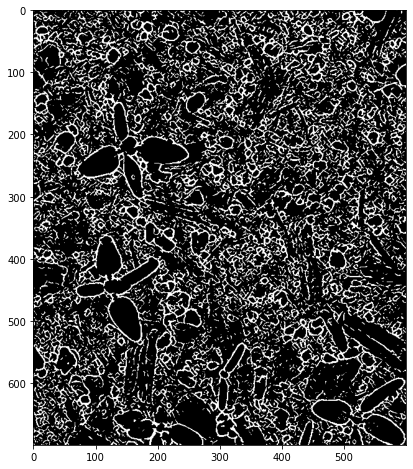

In [6]:
sat = sato(image, black_ridges=True,sigmas=[1], mode="reflect")
sat = sat/sat.max()
plt.figure(figsize=(12,8))
plt.imshow(sat>0.2, cmap = plt.cm.gray)

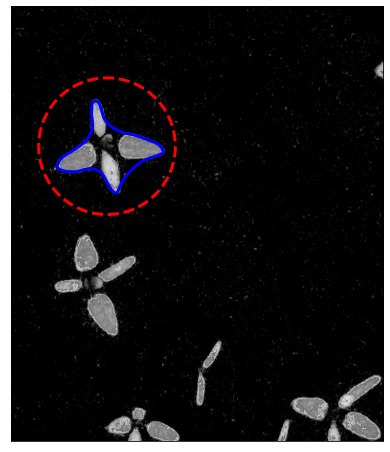

In [7]:

im = cv2.imread(path)
img = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
image = img[2500:3200,7200:7800]
exg = make_exg(image)
exg = thresh_vi(exg, low=20, upper=100, sigma=2)

s = np.linspace(0, 2*np.pi, 400)
r = 225 + 110*np.sin(s)
c = 155 + 110*np.cos(s)
init = np.array([r, c]).T

snake = active_contour(gaussian(exg, 3, preserve_range=False),
                       init, alpha=0.015, beta=10, gamma=0.001)

fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(exg, cmap=plt.cm.gray)

ax.plot(init[:, 1], init[:, 0], '--r', lw=3)
ax.plot(snake[:, 1], snake[:, 0], '-b', lw=3)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, exg.shape[1], exg.shape[0], 0])

plt.show()


Felzenszwalb number of segments: 30
SLIC number of segments: 213


ValueError: NumPy boolean array indexing assignment cannot assign 3 input values to the 28090 output values where the mask is true

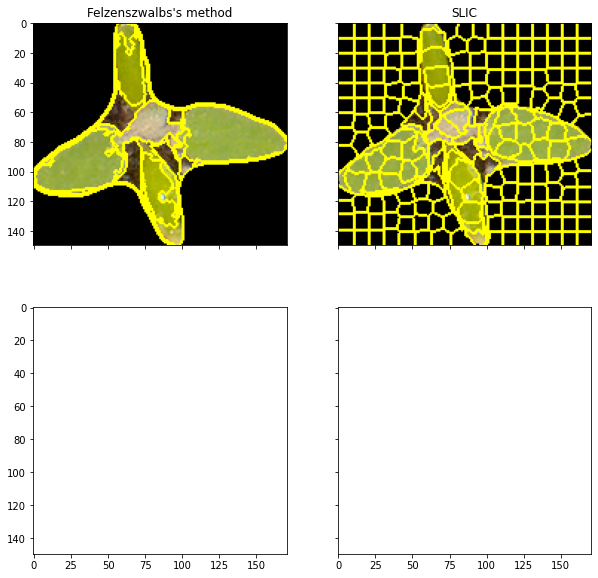

In [14]:
import matplotlib.pyplot as plt
import numpy as np

from skimage.data import astronaut
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float


img = img_as_float(cutout)
new_exg = make_exg(img)
new_exg = thresh_vi(new_exg)

segments_fz = felzenszwalb(img, scale=200, sigma=0.5, min_size=50)

segments_slic = slic(img, n_segments=250, compactness=10, sigma=1,
                     start_label=1)

# segments_quick = quickshift(img, kernel_size=3, max_dist=6, ratio=0.5)

# gradient = sobel(rgb2gray(img))
gradient = sobel(img)

segments_watershed = watershed(gradient, markers=250, compactness=0.00001)

print(f'Felzenszwalb number of segments: {len(np.unique(segments_fz))}')
print(f'SLIC number of segments: {len(np.unique(segments_slic))}')
# print(f'Quickshift number of segments: {len(np.unique(segments_quick))}')

fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

ax[0, 0].imshow(mark_boundaries(img, segments_fz))
ax[0, 0].set_title("Felzenszwalbs's method")
ax[0, 1].imshow(mark_boundaries(img, segments_slic))
ax[0, 1].set_title('SLIC')
# ax[1, 0].imshow(mark_boundaries(img, segments_quick))
# ax[1, 0].set_title('Quickshift')
ax[1, 1].imshow(mark_boundaries(img, segments_watershed))
ax[1, 1].set_title('Compact watershed')

for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()